In [1]:
import os, shutil

In [2]:
base_dir = '/home/skhatter/Transfer_Learning/512_original/'
train_dir = '/home/skhatter/Transfer_Learning/512_original/train'
valid_dir = '/home/skhatter/Transfer_Learning/512_original/validation'

train_dam_dir = '/home/skhatter/Transfer_Learning/512_original/train/damaged'
train_undam_dir = '/home/skhatter/Transfer_Learning/512_original/train/undamaged'

valid_dam_dir = '/home/skhatter/Transfer_Learning/512_original/validation/damaged'
valid_undam_dir = '/home/skhatter/Transfer_Learning/512_original/validation/undamaged'

In [3]:
print('Total training damaged images', len(os.listdir(train_dam_dir)))
print('Total training undamaged images', len(os.listdir(train_undam_dir)))

print('Total validation damaged images', len(os.listdir(valid_dam_dir)))
print('Total validation undamaged images', len(os.listdir(valid_undam_dir)))

Total training damaged images 1501
Total training undamaged images 2541
Total validation damaged images 26
Total validation undamaged images 21


In [4]:
from keras import layers
from keras import models
from keras.applications import VGG19

Using TensorFlow backend.


In [5]:
conv_base = VGG19(weights = 'imagenet', include_top = False, input_shape=(512, 512, 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [8]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 16, 16, 512)       20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33554688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 53,579,329
Trainable params: 42,994,177
Non-trainable params: 10,585,152
_________________________________________________________________


In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255)


train_generator = datagen.flow_from_directory(train_dir,
                                             target_size = (512, 512), 
                                              batch_size = 20,
                                              class_mode = 'binary')


validation_generator = datagen.flow_from_directory(valid_dir,
                                             target_size = (512, 512), 
                                              batch_size = 20,
                                              class_mode = 'binary')
                                              

Found 4040 images belonging to 2 classes.
Found 45 images belonging to 2 classes.


In [10]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=50,
                    epochs=50,  
                    validation_data=validation_generator,
                   validation_steps = 25)

Epoch 1/50
50/50 [==============================] - 60s - loss: 1.1338 - acc: 0.6170 - val_loss: 0.5979 - val_acc: 0.7737
Epoch 2/50
50/50 [==============================] - 56s - loss: 0.5200 - acc: 0.7920 - val_loss: 0.2550 - val_acc: 0.9096
Epoch 3/50
50/50 [==============================] - 57s - loss: 0.3697 - acc: 0.8610 - val_loss: 0.1383 - val_acc: 0.9605
Epoch 4/50
50/50 [==============================] - 57s - loss: 0.3323 - acc: 0.8610 - val_loss: 0.2150 - val_acc: 0.9553
Epoch 5/50
50/50 [==============================] - 56s - loss: 0.2694 - acc: 0.9060 - val_loss: 0.1990 - val_acc: 0.9342
Epoch 6/50
50/50 [==============================] - 57s - loss: 0.2206 - acc: 0.9320 - val_loss: 0.1413 - val_acc: 0.9553
Epoch 7/50
50/50 [==============================] - 57s - loss: 0.2248 - acc: 0.9360 - val_loss: 0.2866 - val_acc: 0.9105
Epoch 8/50
50/50 [==============================] - 56s - loss: 0.2003 - acc: 0.9330 - val_loss: 0.1570 - val_acc: 0.9562
Epoch 9/50
50/50 [======

In [11]:
history_dict = history.history
print(history_dict.keys())

model.save('damage_undamaged_conv3_2_vgg.h5')

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


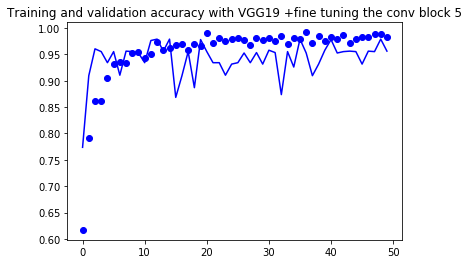

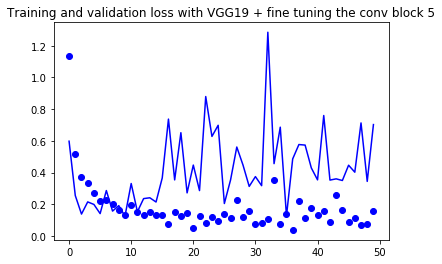

In [12]:
#Displaying curves of loss and accuracy during training 

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')#dots
plt.plot(epochs, val_acc, 'b')#line segments
plt.title('Training and validation accuracy with VGG19 +fine tuning the conv block 5')
plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss with VGG19 + fine tuning the conv block 5')
plt.show()